In [1]:
import pandas as pd
import pickle
import numpy as np
from itertools import combinations
import networkx as nx
import sys
import os

sys.path.append("../code/")
from data_processing import LoadData, get_triadic_closure_links_to_add_at_time_t

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
import palettable as pltt
import matplotlib as mplt
mplt.rcParams['font.sans-serif'] = 'Avenir'

plt.rcParams['xtick.major.width'] = 1.2
plt.rcParams['ytick.major.width'] = 1.2
plt.rcParams['xtick.minor.size'] = 2
plt.rcParams['xtick.minor.width'] = 1.2
plt.rcParams['ytick.minor.size'] = 2
plt.rcParams['ytick.minor.width'] = 1.2
plt.rcParams['axes.linewidth'] = 1.2

In [6]:
#Setting up local directories
DIRs_TO_CREATE = ["figures", "results", "temp"]
        
#Directories for outputs
DIRs_TO_CREATE.extend(["../data-processed/CNS/"])

for directory in DIRs_TO_CREATE:
    if not os.path.exists(directory):
        os.makedirs(directory)

In [2]:
DATA_DIR = "../data-raw/CNS/"
DATA_FILENAMES = {"bluetooth": "bt_symmetric.csv",
                  "calls": "calls.csv",
                  "sms": "sms.csv",
                  "facebook_friends": "fb_friends.csv",
                  "genders": "genders.csv"}

## Loading and preprocessing the bluetooth dataframe 

`timestamp`	Timestamp in seconds from the beginning of the observation period (as reported by the device. Note, that because of differences in the internal clock of different devices, some of the measurements will not be perfectly aligned). Four weeks observation period divided into into 8064 **five minute periods** (4 (weeks) × 7 (days) × 24 (hours) × 12 (five minute periods) = 8064.

`user_a`	ID of one user (ego).

`user_b`	ID of the other user (alter). 0–850 for participants of the study, −1 for empty scans, −2 for any non-participating device.

`rssi`	Received Signal Strength Indication, measured in dBm, a rough proxy for distance between devices (the higher the absolute value, the higher the distance)

In [3]:
df = LoadData(DATA_FILENAMES["bluetooth"], DATA_DIR)
print(len(df))
df.head()

5474289


,# timestamp,user_a,user_b,rssi
0,0,0,-1,0
1,0,1,-1,0
2,0,2,-1,0
3,0,3,-2,-88
4,0,5,-1,0


### Cleaning wrong RSSI
There are 4 entries with RSSI=20 (makes no sense)

In [4]:
df = df[df['rssi']<=0]
print(len(df))

5474285


### Rescaling time
The width of each temporal bin is 300, correspondent to 5 minutes. I divide it so that timestamps are distant 1.

In [5]:
df['# timestamp'] = (df['# timestamp']/300).astype(int)

### Mapping IDs
Some IDs are missing, I will convert them to consecutive ones

In [6]:
#Extracting all the users IDs
users = set(df['user_a'].unique()).union(set(df['user_b'].unique()))
#Removing the placeholder -1 and -2
users.remove(-1)
users.remove(-2)
#Converting to list
users = list(users)
print(len(users)), print(max(users));

706
845


In [7]:
#Dictionaries to keep track of the mapping
old_id_to_new = {}
new_id_to_old = {}

for new_id, old_id in enumerate(users):
    old_id_to_new[old_id]=new_id
    new_id_to_old[new_id]=old_id
    
#Mapping the list of users:
users = [old_id_to_new[ID] for ID in users]

print(len(users)), print(max(users));

706
705


Saving the dictionaries

In [8]:
output_path = "../data-processed/CNS/"

fname = "old_id_to_new_dict.p"
pickle.dump( old_id_to_new, open( output_path+fname, "wb" ) )

fname = "new_id_to_old_dict.p"
pickle.dump( new_id_to_old, open( output_path+fname, "wb" ) )

Replacing the IDs with the new ones, according to the dictionaries

In [9]:
df.replace({'user_a':old_id_to_new}, inplace=True)
df.replace({'user_b':old_id_to_new}, inplace=True)

### Fraction of external vs isolated vs missing vs interacting users?

In [10]:
N = 706 #Real number of users

users_int_data = []

for timestamp in df['# timestamp'].unique():
    dft = df[df['# timestamp']==timestamp]
    
    #Counting users that have real interactions
    users_int = set(dft['user_a'].unique()).union(set(dft['user_b'].unique()))
    users_int.remove(-1)
    users_int.remove(-2)
    N_users_int = len(users_int)
    
    #Counting users that interact solely with out-of-sample users
    users_ext = set(dft[dft['user_b']==-2]['user_a'].unique())
    users_ext = users_ext.difference(users_int) #removing those that interact also internally
    N_users_ext = len(users_ext)
    
    #Counting users that are declared isolated
    users_iso = set(dft[dft['user_b']==-1]['user_a'].unique())
    users_iso = users_iso.difference(users_int) #this is not really necessary, but just to be sure
    N_users_iso = len(users_iso)
    
    N_users_missing = N-(N_users_int+N_users_ext+N_users_iso)
    
    row = [timestamp, N_users_int, N_users_ext, N_users_iso, N_users_missing]
    users_int_data.append(row)
    
    if timestamp%1000==0: print(timestamp)
    
users_int_df = pd.DataFrame(users_int_data, columns=['# timestamp', 'N_users_int', 'N_users_ext',
                                                     'N_users_iso', 'N_users_missing'])

0
1000
2000
3000
4000
5000
6000
7000
8000


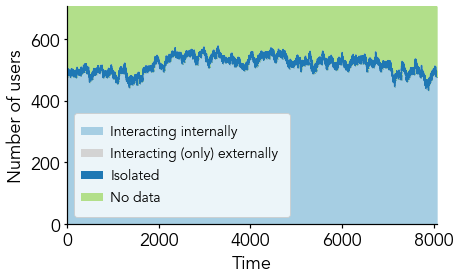

In [13]:
plt.figure(figsize=(6.5, 4))

ax = plt.subplot(111)

users_int_df.plot.area(x='# timestamp', ax=ax,
                      color={'N_users_missing':'#b2df8a', 'N_users_int':'#a6cee3',
                             'N_users_iso':'#1f78b4', 'N_users_ext':'lightgray'})

ax.set_xlabel('Time', size=18)
ax.set_ylabel('Number of users', size=18)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

ax.set_xlim(0, users_int_df['# timestamp'].max())
ax.set_ylim(0, N)

custom_lines = [Line2D([0], [0], color='#a6cee3', lw=8),
                Line2D([0], [0], color='lightgray', lw=8),
                Line2D([0], [0], color='#1f78b4', lw=8),
               Line2D([0], [0], color='#b2df8a', lw=8)]
ax.legend(custom_lines, ["Interacting internally", "Interacting (only) externally", "Isolated", "No data"],
          fontsize=14, handlelength=1, borderpad=0.8);

plt.tight_layout()

filename = "figures/CNS_users_class_in_time.pdf"
plt.savefig(filename, bbox_inches='tight', dpi=150)

### Removing external users
In bins where userA discovered other Bluetooth devices but not other study participants, we reported the alter ID as −2 and the highest received signal strength measured. We do not report the type of the discovered device.

In [14]:
#Removing interactions outside of the tracked users
df = df[df['user_b']!=-2]
print(len(df))

4646411


### Filtering by RSSI
In the paper [https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0100915 ] they filter at -80dBm, saying that it optimizes the ratio between strong and weak links. In a large majority of cases, this corresponds to interactions that occur within a radius of 0-2 meters -- a distance which Hall [https://books.google.it/books/about/The_Hidden_Dimension.html?id=07H4zAEACAAJ] notes as a typical social distance for interactions among close acquaintances.

We filter at -90dBm instead! To get a bit more

In [15]:
#All nonzero values
values = df[df['rssi']!=0]['rssi'].values

#Filtering
filtered_values = df[(df['rssi']!=0)&(df['rssi']>=-90)]['rssi'].values

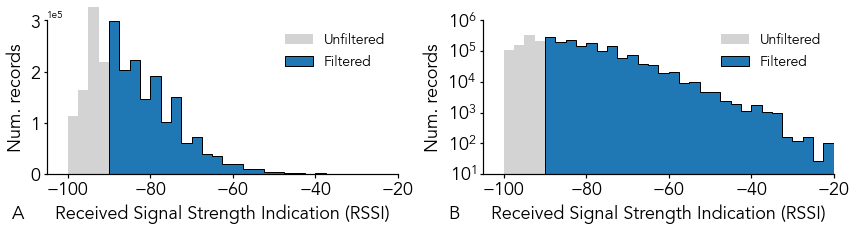

In [18]:
plt.figure(figsize=(12, 3.5))

ax = plt.subplot(121)

ax.hist(values, histtype='stepfilled', color='lightgray',
        bins=np.linspace(-100,-20,33), label='Unfiltered', clip_on=False)
ax.hist(filtered_values, histtype='stepfilled', color='C0', ec="k",
        bins=np.linspace(-100,-20,33), label='Filtered', clip_on=False)

ax.set_xlabel('Received Signal Strength Indication (RSSI)', size=18)
ax.set_ylabel('Num. records', size=18)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.set_xlim(-105, -20)
ax.set_ylim(0, 3e5)

#Scientific notation y-axis
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

ax.legend(frameon=False, fontsize=14)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

ax.annotate('A', xy=(-0.1, -0.29), xycoords="axes fraction", fontsize=18, fontweight="bold")

########################################################################
ax = plt.subplot(122)

ax.hist(values, histtype='stepfilled', color='lightgray',
        bins=np.linspace(-100,-20,33), label='Unfiltered')
ax.hist(filtered_values, histtype='stepfilled', color='C0', ec="k",
        bins=np.linspace(-100,-20,33), label='Filtered')

ax.set_xlabel('Received Signal Strength Indication (RSSI)', size=18)
ax.set_ylabel('Num. records', size=18)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.set_xlim(-105, -20)
ax.set_yscale('log')
ax.set_ylim(1e1, 1e6)
ax.set_yticks([1e1,1e2,1e3,1e4,1e5,1e6])

ax.legend(frameon=False, fontsize=14)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

ax.annotate('B', xy=(-0.1, -0.29), xycoords="axes fraction", fontsize=18, fontweight="bold")

plt.tight_layout()

filename = "figures/CNS_RSSI_filtering.pdf"
plt.savefig(filename, bbox_inches='tight', dpi=150)

In [19]:
df=df[df['rssi']>=-90]

In [20]:
output_path = "temp/"
fname = "CNS_bluetooth_partially_processed.csv"
df.to_csv(output_path+fname, sep=',', header=True, index=False)

In [21]:
print('All records', len(df[df['rssi']!=0]))
print('Pairwise interactions', len(df))
print('Empty scans', len(df[df['rssi']==0]))

All records 1603916
Pairwise interactions 3824052
Empty scans 2220136


## Filling single gaps

In [38]:
output_path = "temp/"
fname = "CNS_bluetooth_partially_processed.csv"
df = pd.read_csv(output_path+fname)
df.head()

,# timestamp,user_a,user_b,rssi
0,0,0,-1,0
1,0,1,-1,0
2,0,2,-1,0
3,0,5,-1,0
4,0,6,-1,0


Now I need to fill the gaps composed by all pairwise interactions that are present at times $t$ and $t+2$ but not at time $t+1$

In [39]:
#Unique pairs of users (real ones, so I remove the records when A has no receiver -> B=-1)
unique_pairs = [(user_a, user_b) for (user_a, user_b), _ in df.groupby(by=['user_a', 'user_b']) if user_b!=-1]

In [ ]:
#I create a list of entries that will be added
entries_to_add = []

for user_a, user_b in unique_pairs:
    #Dataframe of current interactions of ab
    df_ab = df[(df['user_a']==user_a) & (df['user_b']==user_b)]
    for t in df_ab['# timestamp']:
        #Check if an entry at t+2 exists but not at t+1
        if ((df_ab['# timestamp']==t+2).any() & (not (df_ab['# timestamp']==t+1).any())):
            #I add the entry at t+1, the RSSI will be the average
            avg_rssi = (int(df_ab[df_ab['# timestamp']==t]['rssi'])+int(df_ab[df_ab['# timestamp']==t+2]['rssi']))/2
            entries_to_add.append([t+1, user_a, user_b, avg_rssi])
print(len(entries_to_add))

In [31]:
output_path = "temp/"
fname = "entries_to_add.p"
pickle.dump(entries_to_add, open(output_path+fname, "wb" ) )

In [60]:
input_path = "temp/"
fname = "entries_to_add.p"
entries_to_add = pickle.load(open(input_path+fname, "rb" ) )
print(len(entries_to_add))

163349


In [61]:
#I add the new entries to a new dataframe
filled_df = df.copy()

#Converting the entries to dicts
entries_to_add_dict = []
for entry in entries_to_add:
    row = {'# timestamp': entry[0], 'user_a': entry[1],'user_b': entry[2],'rssi': entry[3]}
    entries_to_add_dict.append(row)
    
entries_to_add_df = pd.DataFrame.from_records(entries_to_add_dict)

filled_df = pd.concat([df, entries_to_add_df], ignore_index=True)
print(len(df), len(filled_df), len(filled_df)-len(df))

3824052 3987401 163349


I need to check if I added an interaction in a place where one of the nodes was already registered as isolated (interacting with a -1).

In [62]:
#I start looking for duplicates in the filled dataframe
duplicates = filled_df[filled_df.duplicated(subset=['# timestamp','user_a'], keep=False)]

#Among these, I will look for those that have an empty interaction, and these are those that I'll have to remove
to_remove = duplicates[duplicates['rssi']==0]
print(len(to_remove))

1327


In [63]:
#Removing the wrong entries
filled_df_corrected = filled_df.drop(to_remove.index)
print(len(filled_df)-len(filled_df_corrected))

1327


In [65]:
output_path = "temp/"
fname = "CNS_bluetooth_thresholded_and_filled.csv.gz"
filled_df_corrected.to_csv(output_path+fname, sep=',', header=True, index=False, compression='gzip')

## Removing scattered (5min) interactions
I remove interactions that last for just a single timestamp, that means that are present at $t$ but not at $t-1$ or $t+1$

In [67]:
output_path = "temp/"
fname = "CNS_bluetooth_thresholded_and_filled.csv.gz"
df = pd.read_csv(output_path+fname)
df.head()

,# timestamp,user_a,user_b,rssi
0,0,0,-1,0.0
1,0,1,-1,0.0
2,0,2,-1,0.0
3,0,5,-1,0.0
4,0,6,-1,0.0


In [68]:
#Unique pairs of users (real ones, so I remove the records when A has no receiver -> B=-1)
unique_pairs = [(user_a, user_b) for (user_a, user_b), _ in df.groupby(by=['user_a', 'user_b']) if user_b!=-1]

In [ ]:
#Here I will store the indexes of the interactions to remove
indices_to_remove = []

for user_a, user_b in unique_pairs:
    #Dataframe of current interactions of ab
    df_ab = df[(df['user_a']==user_a) & (df['user_b']==user_b)]
    for t in df_ab['# timestamp']:
        if (df_ab['# timestamp']==t-1).any() or (df_ab['# timestamp']==t+1).any():
            #This is not isolated
            continue
        else:
            #It is isolated, I'll have to remove it
            index_to_drop = df_ab[df_ab['# timestamp']==t].index
            indices_to_remove.append(index_to_drop)
print(len(indices_to_remove))

In [94]:
output_path = "temp/"
fname = "indices_to_remove.p"
pickle.dump(indices_to_remove, open(output_path+fname, "wb" ) )

In [70]:
input_path = "temp/"
fname = "indices_to_remove.p"
indices_to_remove = pickle.load(open(input_path+fname, "rb" ) )

In [71]:
clean_indices_to_remove = [ii[0] for ii in indices_to_remove]

#Removing
df_final = df.drop(clean_indices_to_remove)
print(len(df)-len(df_final))

130935


In [72]:
len(df_final)

3855139

In [73]:
output_path = "temp/"
fname = "CNS_bluetooth_thresholded_filled_and_nosingletons.csv.gz"
df_final.to_csv(output_path+fname, sep=',', header=True, index=False, compression='gzip')

## Closing triangles

In [86]:
output_path = "temp/"
fname = "CNS_bluetooth_thresholded_filled_and_nosingletons.csv.gz"
df = pd.read_csv(output_path+fname)
df.head()

,# timestamp,user_a,user_b,rssi
0,0,0,-1,0.0
1,0,1,-1,0.0
2,0,2,-1,0.0
3,0,5,-1,0.0
4,0,6,-1,0.0


I will iterate over every node and link all the neighbors.

In [94]:
triclo_entries_to_add = []

for timestamp in df['# timestamp'].unique():
    triclo_entries_to_add.extend(get_triadic_closure_links_to_add_at_time_t(df, timestamp))
    if timestamp%1000==0:
        print('Time', timestamp, len(triclo_entries_to_add), 'entries collected')

Time 0 2 entries collected
Time 1000 424567 entries collected
Time 2000 759619 entries collected
Time 3000 1300194 entries collected
Time 4000 2028017 entries collected
Time 5000 2493285 entries collected
Time 6000 2888649 entries collected
Time 7000 3257544 entries collected
Time 8000 3806747 entries collected


In [96]:
triclo_entries_to_add_df = pd.DataFrame.from_records(triclo_entries_to_add)
df_triclo = pd.concat([df, triclo_entries_to_add_df], ignore_index = True)

print(len(df), len(df_triclo), len(df_triclo)-len(df))

3855139 7665833 3810694


In [97]:
output_path = "temp/"
fname = "CNS_bluetooth_thresholded_filled_nosingletons_and_triclo.csv.gz"
df_triclo.to_csv(output_path+fname, sep=',', header=True, index=False, compression='gzip')

## What if we put a threshold on the RSSI for the triadic closure? We can do it a posteriori

In [100]:
#Reading the dataframe with closed triangles 
input_path = "temp/"
fname = "CNS_bluetooth_thresholded_filled_nosingletons_and_triclo.csv.gz"
df_triclo = pd.read_csv(input_path+fname)
print(len(df_triclo))

7665833


In [101]:
#Reading the dataframe before triadic closure
input_path = "temp/"
fname = "CNS_bluetooth_thresholded_filled_and_nosingletons.csv.gz"
df = pd.read_csv(input_path+fname)
print(len(df))

3855139


In [102]:
#This is the dataframe of the links added with the triadic closure
df_tri = df_triclo.drop(df.index, axis=0, inplace=False)
print(len(df_triclo)-len(df), len(df_tri))

3810694 3810694


How many triangles are we closing for each RSSI threshold?

In [106]:
triclo_thresholds = np.arange(-90, -30, 5)
num_added_links = [len(df_tri[df_tri['rssi']>=th]) for th in triclo_thresholds]

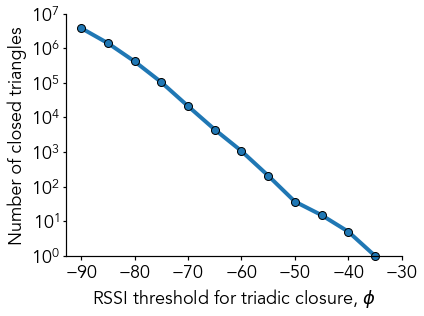

In [108]:
plt.figure(figsize=(6, 4.5))

ax = plt.subplot(111)

ax.plot(triclo_thresholds, num_added_links, 'o-', mec='black', ms=8, lw=4, clip_on=False)

ax.set_xlabel('RSSI threshold for triadic closure, $\phi$', size=18)
ax.set_ylabel('Number of closed triangles', size=18)
ax.tick_params(axis='both', which='major', labelsize=18)

ax.set_yscale('log')
ax.set_ylim(1e0,1e7)
ax.set_yticks([1e0,1e1,1e2,1e3,1e4,1e5,1e6,1e7])
#ax.set_xlim(0, users_int_df['# timestamp'].max())
#ax.set_ylim(0, N)
ax.set_xticks([-90,-80,-70,-60,-50,-40,-30])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

########################################################################
plt.tight_layout()

filename = "figures/CNS_scaling_triclo_RSSI.pdf"
plt.savefig(filename, bbox_inches='tight', dpi=150, transparent=False, facecolor='white')

Saving the dataframes with the thresholded triadic closure. Also converting to datetime.

In [109]:
import datetime as dt

#Creating a dictionary that maps the int. timestamp into datetime.
#We know that is starts on a Sunday, we infer at Midnight from the patterns.
#We know the year, 2013, we arbitrary set the day, which is the first Monday of March (during the School term).

starting_index_t = 0
ending_index_t = df_triclo['# timestamp'].astype(int).max()

starting_dt = dt.datetime(year=2013, month=3, day=3, hour=0, minute=0)
Delta_t = dt.timedelta(minutes=5)
current_dt = starting_dt

dt_converter = {}

for index_t in range(starting_index_t, ending_index_t+1):
    dt_converter[index_t] = current_dt
    current_dt += Delta_t

In [110]:
import datetime as dt

triclo_thresholds = [-90, -85, -80, -75, -70, -65, -60, -55, -50, -45, -40, -35]
num_added_links = []


for th in triclo_thresholds:
    print(th)
    #Dataframe with triclo given the selected threshold
    df_triclo_th = pd.concat([df, df_tri[df_tri['rssi']>=th]])
    
    #Converting timestamp to int
    df_triclo_th['# timestamp'] = df_triclo_th['# timestamp'].astype(int)

    #Converting to datetime
    df_triclo_th['datetime'] = df_triclo_th['# timestamp'].apply(lambda x: dt_converter[x])
    df_triclo_th['DoW'] = df_triclo_th['datetime'].apply(lambda x: x.strftime('%A'))
    df_triclo_th['hour'] = df_triclo_th['datetime'].apply(lambda x: x.hour)
    
    #Saving 
    output_path = "temp/"
    fname = "CNS_bluetooth_thresholded_filled_nosingletons_and_triclo_thr%i_datetime.csv.gz"%(abs(th))
    df_triclo_th.to_csv(output_path+fname, sep=',', header=True, index=False, compression='gzip')

-90
-85
-80
-75
-70
-65
-60
-55
-50
-45
-40
-35


## Selected threshold: $\phi=-75$ [see the other notebook]

### Processing again but finally adding back isolated nodes after triadic closure

Previously, we removed interactions that lasted for 5min only. We need to check if a removed link at time t is the only interaction for one of the two nodes at that time (also considering triadic closure, after the threshold). In that case the node has to be put back, but declared as isolated.

In [113]:
#I first need to get the exact details of the links that I originally removed (I only saved the indices before)

output_path = "temp/"
fname = "CNS_bluetooth_thresholded_and_filled.csv.gz"
df = pd.read_csv(output_path+fname)

output_path = "temp/"
fname = "indices_to_remove.p"
removed_indices = pickle.load(open(output_path+fname, "rb" ) )

removed_entries = []

for ix_removed in removed_indices:
    df_ix = df.iloc[ix_removed]
    #These are time and IDs of the nodes of the link I removed
    t, a, b = df_ix['# timestamp'].values[0], df_ix['user_a'].values[0], df_ix['user_b'].values[0]
    removed_entries.append([t, a, b])
len(removed_entries)

130935

In [115]:
#I now filter by triadic closure

th=-75

output_path = "temp/"
fname = "CNS_bluetooth_thresholded_filled_nosingletons_and_triclo_thr%i_datetime.csv.gz"%(abs(th))
df = pd.read_csv(output_path+fname, sep=',')
df.head()

,# timestamp,user_a,user_b,rssi,datetime,DoW,hour
0,0,0,-1,0.0,2013-03-03 00:00:00,Sunday,0
1,0,1,-1,0.0,2013-03-03 00:00:00,Sunday,0
2,0,2,-1,0.0,2013-03-03 00:00:00,Sunday,0
3,0,5,-1,0.0,2013-03-03 00:00:00,Sunday,0
4,0,6,-1,0.0,2013-03-03 00:00:00,Sunday,0


In [116]:
isolated_nodes_to_add_back = []

for ii, entry in enumerate(removed_entries):
    if ii%1000==0: print(ii)
    #These are time and IDs of the nodes of the link I removed
    t, a, b = entry
    #Checking all interactions of node a at time t (either as a or b)
    df_t_a = df[(df['# timestamp']==t)&((df['user_a']==a)|(df['user_b']==a))]
    if len(df_t_a)==0: #it means that the removed link was the only interaction for a at t
        isolated_nodes_to_add_back.append([t, a, -1, 0])
    #Checking all interactions of node b at time t (either as a or b)
    df_t_b = df[(df['# timestamp']==t)&((df['user_a']==b)|(df['user_b']==b))]
    if len(df_t_b)==0: #it means that the removed link was the only interaction for b at t
        isolated_nodes_to_add_back.append([t, b, -1, 0])

df_isolated_nodes_to_add_back = pd.DataFrame(isolated_nodes_to_add_back,
                                            columns=['# timestamp','user_a','user_b','rssi'])
df_isolated_nodes_to_add_back.head()

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000


,# timestamp,user_a,user_b,rssi
0,4489,1,-1,0
1,463,5,-1,0
2,463,3,-1,0
3,2488,3,-1,0
4,5644,5,-1,0


In [117]:
print(len(df_isolated_nodes_to_add_back))

44941


Adding to these new entry the datetime information as well

In [118]:
#Converting timestamp to int
df_isolated_nodes_to_add_back['# timestamp'] = df_isolated_nodes_to_add_back['# timestamp'].astype(int)

#Converting to datetime
df_isolated_nodes_to_add_back['datetime'] = df_isolated_nodes_to_add_back['# timestamp'].apply(lambda x: dt_converter[x])
df_isolated_nodes_to_add_back['DoW'] = df_isolated_nodes_to_add_back['datetime'].apply(lambda x: x.strftime('%A'))
df_isolated_nodes_to_add_back['hour'] = df_isolated_nodes_to_add_back['datetime'].apply(lambda x: x.hour)

df_isolated_nodes_to_add_back.head()

,# timestamp,user_a,user_b,rssi,datetime,DoW,hour
0,4489,1,-1,0,2013-03-18 14:05:00,Monday,14
1,463,5,-1,0,2013-03-04 14:35:00,Monday,14
2,463,3,-1,0,2013-03-04 14:35:00,Monday,14
3,2488,3,-1,0,2013-03-11 15:20:00,Monday,15
4,5644,5,-1,0,2013-03-22 14:20:00,Friday,14


In [119]:
output_path = "temp/"
fname = "CNS_isolated_nodes_to_add_back_after_triclo_thr%i_datetime.csv.gz"%(abs(th))
df_isolated_nodes_to_add_back.to_csv(output_path+fname, sep=',', header=True, index=False, compression='gzip')

Finally merging everything!

In [129]:
th=-75
input_path = "temp/"
fname = "CNS_isolated_nodes_to_add_back_after_triclo_thr%i_datetime.csv.gz"%(abs(th))
df_isolated_nodes_to_add_back = pd.read_csv(input_path+fname)
df_isolated_nodes_to_add_back.head()

,# timestamp,user_a,user_b,rssi,datetime,DoW,hour
0,4489,1,-1,0,2013-03-18 14:05:00,Monday,14
1,463,5,-1,0,2013-03-04 14:35:00,Monday,14
2,463,3,-1,0,2013-03-04 14:35:00,Monday,14
3,2488,3,-1,0,2013-03-11 15:20:00,Monday,15
4,5644,5,-1,0,2013-03-22 14:20:00,Friday,14


In [130]:
th=-75
input_path = "temp/"
fname = "CNS_bluetooth_thresholded_filled_nosingletons_and_triclo_thr%i_datetime.csv.gz"%(abs(th))
df = pd.read_csv(input_path+fname, sep=',')
df.head()

,# timestamp,user_a,user_b,rssi,datetime,DoW,hour
0,0,0,-1,0.0,2013-03-03 00:00:00,Sunday,0
1,0,1,-1,0.0,2013-03-03 00:00:00,Sunday,0
2,0,2,-1,0.0,2013-03-03 00:00:00,Sunday,0
3,0,5,-1,0.0,2013-03-03 00:00:00,Sunday,0
4,0,6,-1,0.0,2013-03-03 00:00:00,Sunday,0


In [131]:
#Merging
final_df = pd.concat([df, df_isolated_nodes_to_add_back])
print(len(final_df))

#Just for safety, removing duplicates
final_df = final_df.drop_duplicates(subset=['# timestamp', 'user_a', 'user_b', 'rssi'])
print(len(final_df))

#Fixing dtypes
final_df['user_a'] = final_df['user_a'].astype(int)
final_df['user_b'] = final_df['user_b'].astype(int)
final_df['rssi'] = final_df['rssi'].astype(int)

final_df.head()

4004139
3991474


,# timestamp,user_a,user_b,rssi,datetime,DoW,hour
0,0,0,-1,0,2013-03-03 00:00:00,Sunday,0
1,0,1,-1,0,2013-03-03 00:00:00,Sunday,0
2,0,2,-1,0,2013-03-03 00:00:00,Sunday,0
3,0,5,-1,0,2013-03-03 00:00:00,Sunday,0
4,0,6,-1,0,2013-03-03 00:00:00,Sunday,0


In [132]:
output_path = "../data-processed/CNS/"
fname = "CNS_bluetooth_processed.csv.gz"
final_df.to_csv(output_path+fname, sep=',', header=True, index=False, compression='gzip')